In [72]:
import pandas as pd
import re
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib import pyplot as plt

In [73]:
# read in data
df = pd.read_csv('/Users/peterxu/Documents/USC/学习/Senior_Spring/MATH446/Datasets/scores.csv')

In [74]:
# clean quiz data by filling missing quizes with 0
df.loc[:, df.columns.str.startswith('quiz_')] = df.loc[:, df.columns.str.startswith('quiz_')].fillna(0)
df.head()

,student_id,final,midterm_1,midterm_2,midterm_3,quiz_1,quiz_2,quiz_3,quiz_4,quiz_5,quiz_6,quiz_7,quiz_8,quiz_9,quiz_10,quiz_11
0,3422798597,99.0,87.0,80.0,89.0,7.0,9.0,10.0,3.0,8.0,8.0,10.0,7.0,6.0,6.0,10.0
1,6680270432,83.0,57.0,53.0,62.0,8.0,9.5,8.0,10.0,9.0,7.0,8.0,9.0,8.0,7.0,6.5
2,3687160969,114.0,98.0,91.0,96.0,7.0,9.0,10.0,8.0,10.0,9.0,10.0,9.0,9.0,10.0,9.0
3,8918171989,87.0,57.0,88.0,60.0,10.0,7.0,7.0,3.0,10.0,10.0,7.0,10.0,4.0,4.0,9.0
4,2933314271,115.0,100.0,86.0,96.0,10.0,9.5,10.0,9.5,9.5,6.5,10.0,10.0,9.5,9.0,7.0


In [75]:
# find minimum value for each student and record the unique quiz where the student has a minimium
min_values = df.iloc[:,5:].min(axis=1)
min_column_index = df.iloc[:,5:].eq(min_values, axis=0).idxmax(axis=1)
# fill in minimum with NaN
for i in range(0,60):
    df.loc[i, min_column_index[i]] = np.nan
# repeat the previous to fill the second lowest quiz with NaN
min_values = df.iloc[:,5:].min(axis=1)
min_column_index = df.iloc[:,5:].eq(min_values, axis=0).idxmax(axis=1)
for i in range(0,60):
    df.loc[i, min_column_index[i]] = np.nan
df.head()

,student_id,final,midterm_1,midterm_2,midterm_3,quiz_1,quiz_2,quiz_3,quiz_4,quiz_5,quiz_6,quiz_7,quiz_8,quiz_9,quiz_10,quiz_11
0,3422798597,99.0,87.0,80.0,89.0,7.0,9.0,10.0,NaN,8.0,8.0,10.0,7.0,NaN,6.0,10.0
1,6680270432,83.0,57.0,53.0,62.0,8.0,9.5,8.0,10.0,9.0,NaN,8.0,9.0,8.0,7.0,NaN
2,3687160969,114.0,98.0,91.0,96.0,NaN,9.0,10.0,NaN,10.0,9.0,10.0,9.0,9.0,10.0,9.0
3,8918171989,87.0,57.0,88.0,60.0,10.0,7.0,7.0,NaN,10.0,10.0,7.0,10.0,NaN,4.0,9.0
4,2933314271,115.0,100.0,86.0,96.0,10.0,9.5,10.0,9.5,9.5,NaN,10.0,10.0,9.5,9.0,NaN


In [76]:
# calculate quiz average
quiz_avg = df.iloc[:,5:].mean(axis=1)
df['quiz_avg'] = quiz_avg
df_new = df[['student_id', 'quiz_avg', 'midterm_1', 'midterm_2', 'midterm_3', 'final']]
df_new.head()

,student_id,quiz_avg,midterm_1,midterm_2,midterm_3,final
0,3422798597,8.333333,87.0,80.0,89.0,99.0
1,6680270432,8.500000,57.0,53.0,62.0,83.0
2,3687160969,9.444444,98.0,91.0,96.0,114.0
3,8918171989,8.222222,57.0,88.0,60.0,87.0
4,2933314271,9.666667,100.0,86.0,96.0,115.0


In [77]:
# drop students who have not taken at least two midterms and a final
# create filter for matching condition
filter_mt = df_new.iloc[:,2:5].isna().sum(axis=1)>=2
filter_fl = df_new.iloc[:,5].isna()
# map the filters to df to drop
df_new = df_new[~filter_mt]
df_new = df_new[~filter_fl]
df_new = df_new.reset_index(drop=True)
df_new.head()

,student_id,quiz_avg,midterm_1,midterm_2,midterm_3,final
0,3422798597,8.333333,87.0,80.0,89.0,99.0
1,6680270432,8.500000,57.0,53.0,62.0,83.0
2,3687160969,9.444444,98.0,91.0,96.0,114.0
3,8918171989,8.222222,57.0,88.0,60.0,87.0
4,2933314271,9.666667,100.0,86.0,96.0,115.0


In [78]:
# find null midterm values
ind, col = np.where(pd.isnull(df_new.iloc[:,2:5]))
# create a reference list to identify which student missed which midterm
ref_list = ['midterm_1', 'midterm_2', 'midterm_3']
# record which student missed which midterm
stu1_ind = ind[0]
stu1_col = ref_list[col[0]]
stu2_ind = ind[1]
stu2_col = ref_list[col[1]]

In [79]:
print('Student 1: index', stu1_ind, 'missing', stu1_col)
print('Student 2: index', stu2_ind, 'missing', stu2_col)

Student 1: index 29 missing midterm_3
Student 2: index 47 missing midterm_1


In [80]:
# build regression model on each student
# construct X data
X_stu1 = df_new['quiz_avg'].drop(stu1_ind).values.reshape(-1,1)
X_stu2 = df_new['quiz_avg'].drop(stu2_ind).values.reshape(-1,1)
# construct y data
y_stu1 = df_new[stu1_col].dropna()
y_stu2 = df_new[stu2_col].dropna()
# construct the model
model_stu1 = LinearRegression().fit(X_stu1, y_stu1)
model_stu2 = LinearRegression().fit(X_stu2, y_stu2)
# predict midterm scores
stu1_x = df_new['quiz_avg'][stu1_ind].reshape(-1,1)
stu2_x = df_new['quiz_avg'][stu2_ind].reshape(-1,1)
stu1_pred = model_stu1.predict(stu1_x)[0]
stu2_pred = model_stu1.predict(stu2_x)[0]
# plug prediction back to dataframe
df_new.loc[stu1_ind, stu1_col] = stu1_pred
df_new.loc[stu2_ind, stu2_col] = stu2_pred

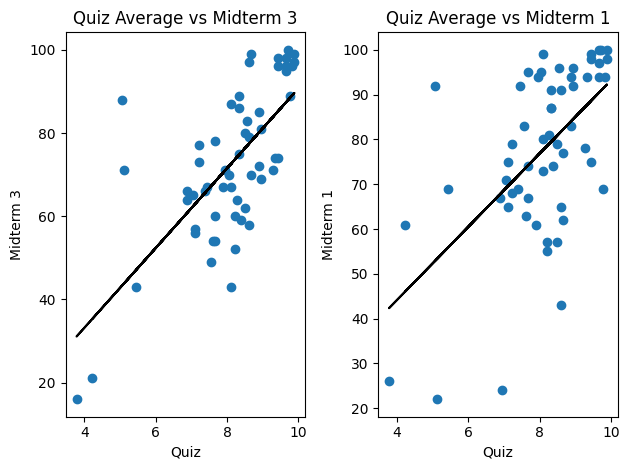

In [81]:
# plot regession models
fig, ax = plt.subplots(1,2)
x_1 = df_new['quiz_avg'].drop(stu1_ind)
x_2 = df_new['quiz_avg'].drop(stu2_ind)
ax[0].scatter(x_1, y_stu1)
ax[0].plot(x_1, model_stu1.coef_*x_1 + model_stu1.intercept_, 'k')
ax[1].scatter(x_2, y_stu2)
ax[1].plot(x_2, model_stu2.coef_*x_2 + model_stu2.intercept_, 'k')
ax[0].set(title='Quiz Average vs Midterm 3', xlabel='Quiz', ylabel='Midterm 3')
ax[1].set(title='Quiz Average vs Midterm 1', xlabel='Quiz', ylabel='Midterm 1')
plt.tight_layout()
plt.show()

In [82]:
# find midterm average
df_midterms = pd.DataFrame(np.sort(df_new.iloc[:,2:5])[:,::-1])
mt_avg = df_midterms.iloc[:,0]*0.45 + df_midterms.iloc[:,1]*0.35 + df_midterms.iloc[:,2]*0.2
df_new['mt_avg'] = mt_avg
df_new_mt_avg = df_new[['student_id', 'quiz_avg', 'mt_avg', 'final']]
df_new_mt_avg.head()

,student_id,quiz_avg,mt_avg,final
0,3422798597,8.333333,86.50,99.0
1,6680270432,8.500000,58.45,83.0
2,3687160969,9.444444,95.90,114.0
3,8918171989,8.222222,72.00,87.0
4,2933314271,9.666667,95.80,115.0


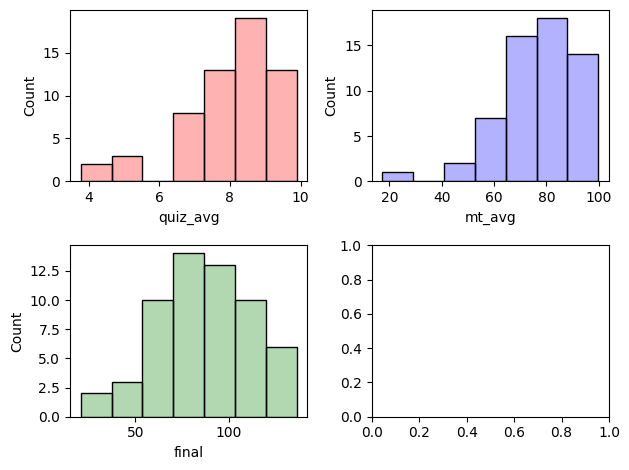

In [83]:
# plot histogram on quiz, mt, and final to determine the use of cutoffs
fig, ax = plt.subplots(2,2)
sns.histplot(df_new_mt_avg, x="quiz_avg", fill=True, alpha=0.3, bins =7, color='red', ax=ax[0,0]);
sns.histplot(df_new_mt_avg, x="mt_avg", fill=True, alpha=0.3, bins =7, color='blue', ax=ax[0,1]);
sns.histplot(df_new_mt_avg, x="final", fill=True, alpha=0.3, bins =7, color='green', ax=ax[1,0]);
fig.tight_layout()

From the histograms above, we can find that the averages for quiz, miterm, and final are all around 70% to 80%. With a few outliers, an equally-spaced cutoff with 12 segmentations would work for the data here.

In [84]:
# cutoffs: use .quantile method and customize to be 12 quantiles to match the available GPA options
# cutoff for quiz
cut_offs_quiz = df_new_mt_avg['quiz_avg'].quantile(np.arange(0, 1 + 1/12, 1/12))
cut_offs_quiz[0] = 0
# cutoff for midterm
cut_offs_mt = df_new_mt_avg['mt_avg'].quantile(np.arange(0, 1 + 1/12, 1/12))
cut_offs_mt[0] = 0
# cutoff for final
cut_offs_final = df_new_mt_avg['final'].quantile(np.arange(0, 1 + 1/12, 1/12))
cut_offs_final[0] = 0
cut_offs_quiz.head()

0.000000    0.000000
0.083333    6.527778
0.166667    7.111111
0.250000    7.472222
0.333333    7.666667
Name: quiz_avg, dtype: float64

In [85]:
# use pd.cut to map cutoffs back to original grades
curved_quiz = pd.cut(df_new_mt_avg['quiz_avg'], bins=cut_offs_quiz, include_lowest=True, ordered=True, precision=2)
curved_mt = pd.cut(df_new_mt_avg['mt_avg'], bins=cut_offs_mt, include_lowest=True, ordered=True, precision=2)
curved_final = pd.cut(df_new_mt_avg['final'], bins=cut_offs_final, include_lowest=True, ordered=True, precision=2)
# use .cat to handle categorical data and do a rename
curved_quiz.cat.categories
curved_mt.cat.categories
curved_final.cat.categories
letters = ["F", "D-", "D", "D+", "C-", "C", "C+", "B-", "B", "B+", "A-", "A"]
# map letter grades to cutoffs by renaming
df_new_mt_avg['curved_quiz_lettergrade'] = curved_quiz.cat.rename_categories(letters)
df_new_mt_avg['curved_mt_lettergrade'] = curved_mt.cat.rename_categories(letters)
df_new_mt_avg['curved_final_lettergrade'] = curved_final.cat.rename_categories(letters)

/var/folders/cm/ylzm16q53fgck3vjks9517yc0000gn/T/ipykernel_79520/411502228.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_mt_avg['curved_quiz_lettergrade'] = curved_quiz.cat.rename_categories(letters)
/var/folders/cm/ylzm16q53fgck3vjks9517yc0000gn/T/ipykernel_79520/411502228.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_mt_avg['curved_mt_lettergrade'] = curved_mt.cat.rename_categories(letters)


In [86]:
# assign GPA on letter grade using merge
# create a reference dataframe for conversion
letter_value_dict = {'letter': ["F", "D-", "D", "D+", "C-", "C", "C+", "B-", "B", "B+", "A-", "A"],
                     'value': sorted([4, 3.7, 3.3, 3, 2.7, 2.3, 2, 1.7, 1.3, 1, 0.7, 0])}
letter_value_df = pd.DataFrame(letter_value_dict)
# record index
indices = df_new_mt_avg.index
# merge dataframe
df_new_mt_avg = df_new_mt_avg.merge(letter_value_df, left_on='curved_quiz_lettergrade', right_on='letter', 
                          indicator=False).drop(columns='letter')
df_new_mt_avg = df_new_mt_avg.rename(columns={'value': 'curved_quiz_gpa'})

df_new_mt_avg = df_new_mt_avg.merge(letter_value_df, left_on='curved_mt_lettergrade', right_on='letter', 
                          indicator=False).drop(columns='letter')
df_new_mt_avg = df_new_mt_avg.rename(columns={'value': 'curved_mt_gpa'})

df_new_mt_avg = df_new_mt_avg.merge(letter_value_df, left_on='curved_final_lettergrade', right_on='letter', 
                          indicator=False).drop(columns='letter')
df_new_mt_avg.index = indices

# formatting: rename and drop columns
df_new_mt_avg = df_new_mt_avg.rename(columns={'value': 'curved_final_gpa'})
df_curved_gpa = df_new_mt_avg.drop(columns=['quiz_avg', 'mt_avg', 'final', 'curved_quiz_lettergrade', 
                                             'curved_mt_lettergrade', 'curved_final_lettergrade'])

In [87]:
df_curved_gpa.head()

,student_id,curved_quiz_gpa,curved_mt_gpa,curved_final_gpa
0,3422798597,2.3,3.0,2.7
1,6379738428,3.0,1.7,2.7
2,3053107449,4.0,4.0,2.7
3,8854235913,1.7,2.3,2.7
4,1367593690,0.7,1.0,2.7


In [88]:
# calculate total weighted results
df_curved_gpa['weighted_total_gpa'] = 0.15*df_curved_gpa['curved_quiz_gpa'] + 0.45*df_curved_gpa['curved_mt_gpa'] + \
                                        0.4*df_curved_gpa['curved_final_gpa']
df_curved_gpa.head()

,student_id,curved_quiz_gpa,curved_mt_gpa,curved_final_gpa,weighted_total_gpa
0,3422798597,2.3,3.0,2.7,2.775
1,6379738428,3.0,1.7,2.7,2.295
2,3053107449,4.0,4.0,2.7,3.480
3,8854235913,1.7,2.3,2.7,2.370
4,1367593690,0.7,1.0,2.7,1.635


In [89]:
# assign total letter grade
# define cutoff
cut_offs_total = pd.Series([0, 0.55, 0.85, 1.15,1.55, 1.85, 2.15,2.55, 2.85, 3.15, 3.55, 3.85, 4]). \
                    quantile(np.arange(0, 1 + 1/12, 1/12))
# use cut to map weighted total gpa to given cutoff
curved_total = pd.cut(df_curved_gpa['weighted_total_gpa'], bins=cut_offs_total, include_lowest=True, 
                      ordered=True, precision=2)
# use .cat to handle categorical data and do a rename
curved_total.cat.categories
# map letter grades to cutoffs by renaming
df_curved_gpa['weighted_total_lettergrade'] = curved_total.cat.rename_categories(letters)
df_curved_gpa.sort_values(by='weighted_total_lettergrade', ascending=False)


,student_id,curved_quiz_gpa,curved_mt_gpa,curved_final_gpa,weighted_total_gpa,weighted_total_lettergrade
50,6011937372,4.0,4.0,4.0,4.000,A
51,8223787343,4.0,4.0,4.0,4.000,A
48,5856390535,4.0,3.7,4.0,3.865,A
49,4916395511,3.3,4.0,4.0,3.895,A
18,4188332510,3.7,4.0,3.3,3.675,A-
45,2933314271,3.7,3.7,3.7,3.700,A-
44,3687160969,3.3,3.7,3.7,3.640,A-
46,2328480380,2.7,3.3,3.7,3.370,B+
17,9882408935,3.7,3.7,3.3,3.540,B+
15,4426198523,3.3,3.0,3.3,3.165,B+
